In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.6 MB/s eta 0:00:00


# 1. Import libraries

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

# 2. Configuration

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [5]:
base_path = "/content/drive/My Drive/Brain_Tumor_Detection_Segmentation/brisc2025/segmentation_task/train"
images_dir = os.path.join(base_path, "images")
masks_dir  = os.path.join(base_path, "masks")

In [6]:
test_images_dir = "/content/drive/My Drive/Brain_Tumor_Detection_Segmentation/brisc2025/segmentation_task/test/images"
test_masks_dir  = "/content/drive/My Drive/Brain_Tumor_Detection_Segmentation/brisc2025/segmentation_task/test/masks"

# 3. Data preprocessing

In [7]:
class BrainTumorDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # mask grayscale

        if self.transform:
            seed = np.random.randint(2147483647)
            torch.manual_seed(seed)
            image = self.transform(image)
            torch.manual_seed(seed)
            mask = self.transform(mask)

        mask = torch.round(mask)
        return image, mask

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

In [9]:
full_train_ds = BrainTumorDataset(images_dir, masks_dir, transform=train_transform)

In [10]:
# split training set and validation set
train_size = int(0.8 * len(full_train_ds))
val_size   = len(full_train_ds) - train_size
train_ds, val_ds = random_split(full_train_ds, [train_size, val_size])

In [11]:
val_ds.dataset.transform = val_transform

In [12]:
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False)

In [13]:
test_ds = BrainTumorDataset(test_images_dir, test_masks_dir, transform=val_transform)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False)

# 4. ResUNet

In [14]:
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: a45f492c-b3ca-4ed4-aba6-b8d978a5640b)')' thrown while requesting HEAD https://huggingface.co/smp-hub/resnet18.imagenet/resolve/3f2325ff978283d47aa6a1d6878ca20565622683/config.json
Retrying in 1s [Retry 1/5].


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [15]:
# loss function and optimizer
loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [16]:
def enable_dropout(model):
    """Bật dropout trong lúc eval để MC Dropout"""
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()

In [17]:
# training phase
num_epochs = 20
best_loss = np.inf

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*imgs.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()*imgs.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_resunet.pth")
        print("Saved best model!")

100%|██████████| 517/517 [13:50<00:00,  1.61s/it]


Epoch 1/20 - Train Loss: 0.6686 - Val Loss: 0.3707
Saved best model!


100%|██████████| 517/517 [00:51<00:00, 10.10it/s]


Epoch 2/20 - Train Loss: 0.2453 - Val Loss: 0.2383
Saved best model!


100%|██████████| 517/517 [00:50<00:00, 10.17it/s]


Epoch 3/20 - Train Loss: 0.1760 - Val Loss: 0.1936
Saved best model!


100%|██████████| 517/517 [00:51<00:00, 10.07it/s]


Epoch 4/20 - Train Loss: 0.1512 - Val Loss: 0.1915
Saved best model!


100%|██████████| 517/517 [00:50<00:00, 10.26it/s]


Epoch 5/20 - Train Loss: 0.1270 - Val Loss: 0.1640
Saved best model!


100%|██████████| 517/517 [00:50<00:00, 10.17it/s]


Epoch 6/20 - Train Loss: 0.1158 - Val Loss: 0.1490
Saved best model!


100%|██████████| 517/517 [00:50<00:00, 10.22it/s]


Epoch 7/20 - Train Loss: 0.1094 - Val Loss: 0.1591


100%|██████████| 517/517 [00:50<00:00, 10.28it/s]


Epoch 8/20 - Train Loss: 0.1000 - Val Loss: 0.1662


100%|██████████| 517/517 [00:50<00:00, 10.22it/s]


Epoch 9/20 - Train Loss: 0.1056 - Val Loss: 0.1616


100%|██████████| 517/517 [00:50<00:00, 10.28it/s]


Epoch 10/20 - Train Loss: 0.1020 - Val Loss: 0.1712


100%|██████████| 517/517 [00:50<00:00, 10.28it/s]


Epoch 11/20 - Train Loss: 0.0937 - Val Loss: 0.1508


100%|██████████| 517/517 [00:50<00:00, 10.30it/s]


Epoch 12/20 - Train Loss: 0.0886 - Val Loss: 0.1638


100%|██████████| 517/517 [00:50<00:00, 10.18it/s]


Epoch 13/20 - Train Loss: 0.0818 - Val Loss: 0.1582


100%|██████████| 517/517 [00:50<00:00, 10.31it/s]


Epoch 14/20 - Train Loss: 0.0889 - Val Loss: 0.1754


100%|██████████| 517/517 [00:50<00:00, 10.26it/s]


Epoch 15/20 - Train Loss: 0.0854 - Val Loss: 0.1434
Saved best model!


100%|██████████| 517/517 [00:50<00:00, 10.33it/s]


Epoch 16/20 - Train Loss: 0.0819 - Val Loss: 0.1462


100%|██████████| 517/517 [00:50<00:00, 10.32it/s]


Epoch 17/20 - Train Loss: 0.0749 - Val Loss: 0.1444


100%|██████████| 517/517 [00:50<00:00, 10.34it/s]


Epoch 18/20 - Train Loss: 0.0719 - Val Loss: 0.1393
Saved best model!


100%|██████████| 517/517 [00:50<00:00, 10.26it/s]


Epoch 19/20 - Train Loss: 0.0709 - Val Loss: 0.1562


100%|██████████| 517/517 [00:49<00:00, 10.36it/s]


Epoch 20/20 - Train Loss: 0.0692 - Val Loss: 0.1469


In [18]:
def predict_mask(image_path, model):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor()
    ])
    img_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        mask_pred = torch.sigmoid(output)
        mask_pred = (mask_pred > 0.5).float()
    return mask_pred.squeeze(0).cpu().numpy()

def predict_mask_mc(image_path, model, T=10):
    """
    MC Dropout prediction for uncertainty estimation
    Args:
        image_path: path to image
        model: trained Unet
        T: number of stochastic forward passes
    Returns:
        mean_mask: mean predicted mask
        std_mask: std deviation mask (uncertainty)
    """
    model.eval()
    enable_dropout(model)  # bật dropout
    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)

    preds = []
    for _ in range(T):
        output = model(img_tensor)
        output = torch.sigmoid(output)
        preds.append(output.cpu().detach().numpy())

    preds = np.array(preds)  # shape: [T, 1, H, W]
    mean_mask = preds.mean(axis=0).squeeze(0)
    std_mask = preds.std(axis=0).squeeze(0)

    return mean_mask, std_mask


In [22]:
def visualize_prediction(model, dataset, idx=0):
    model.eval()
    image, true_mask = dataset[idx]

    img_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        pred_mask = torch.sigmoid(output)
        pred_mask = (pred_mask > 0.5).float().squeeze(0).cpu()

    img_np = image.permute(1,2,0).cpu().numpy()
    true_mask_np = true_mask.squeeze(0).cpu().numpy()
    pred_mask_np = pred_mask.squeeze(0).cpu().numpy()

    fig, axes = plt.subplots(1,3, figsize=(15,5))
    axes[0].imshow(img_np)
    axes[0].set_title("MRI gốc")
    axes[0].axis("off")

    axes[1].imshow(true_mask_np, cmap="gray")
    axes[1].set_title("Mask thật")
    axes[1].axis("off")

    axes[2].imshow(pred_mask_np, cmap="gray")
    axes[2].set_title("Mask dự đoán")
    axes[2].axis("off")

    plt.show()

def visualize_prediction_mc(image_path, model, T=10):
    mean_mask, std_mask = predict_mask_mc(image_path, model, T=T)

    image = Image.open(image_path).convert("RGB")
    image = np.array(image.resize((256,256)))

    fig, axes = plt.subplots(1,3, figsize=(18,6))
    axes[0].imshow(image)
    axes[0].set_title("MRI gốc")
    axes[0].axis("off")

    axes[1].imshow(mean_mask.squeeze(), cmap="gray")
    axes[1].set_title(f"Mean Mask")
    axes[1].axis("off")

    axes[2].imshow(std_mask.squeeze(), cmap="hot")
    axes[2].set_title(f"Uncertainty (Std)")
    axes[2].axis("off")

    plt.show()

    print(f"Mask mean: {mean_mask.mean():.4f} ± {std_mask.mean():.4f}")


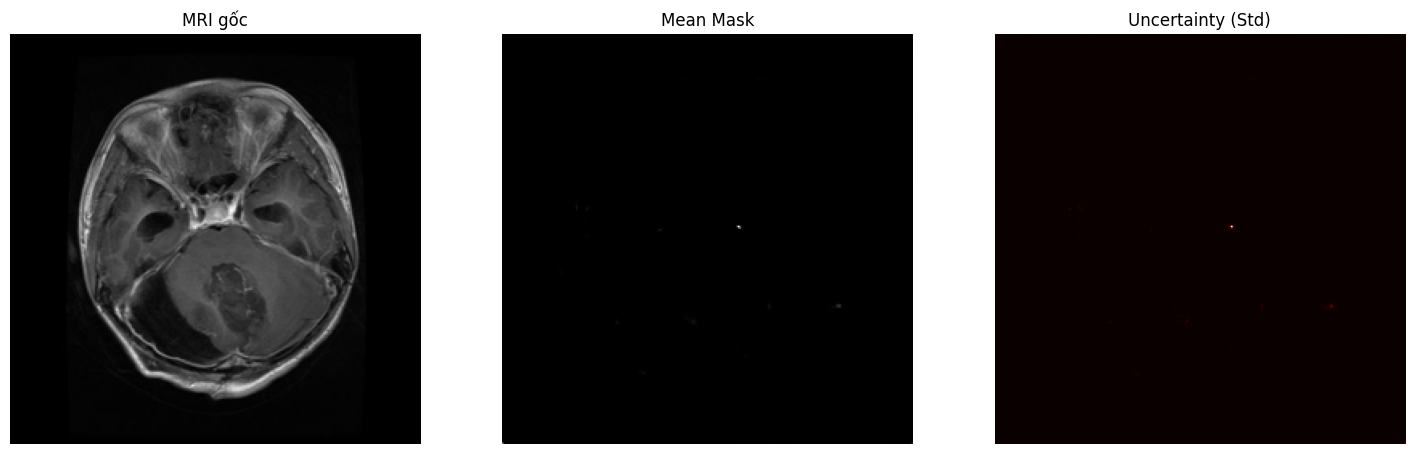

Mask mean: 0.0000 ± 0.0000


In [23]:
model.load_state_dict(torch.load("best_resunet.pth"))
model.to(device)

sample_image = "/content/drive/MyDrive/Brain_Tumor_Detection_Segmentation/brisc2025/segmentation_task/test/images/brisc2025_test_00001_gl_ax_t1.jpg"
visualize_prediction_mc(sample_image, model, T=10)


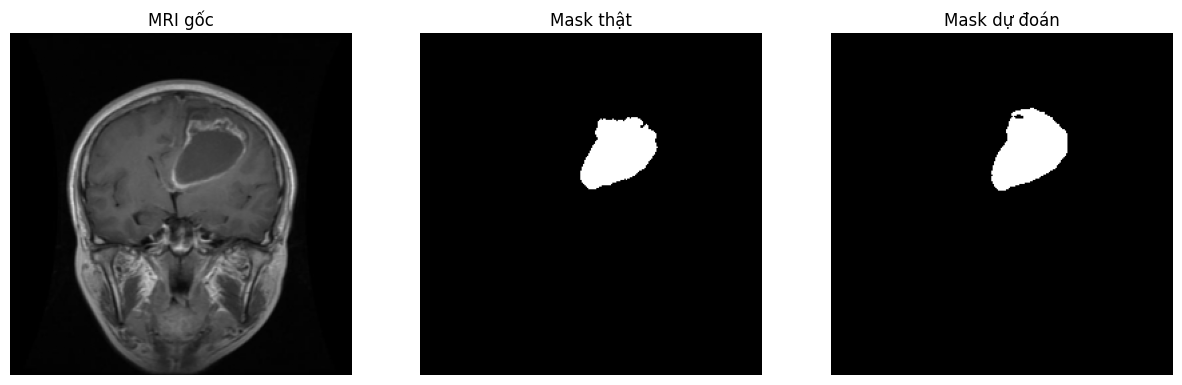

In [29]:
visualize_prediction(model, test_ds, idx=90)